### Installing Libraries

In [1]:
!pip install translators --upgrade --quiet

### Importing Libraries

In [53]:
import pandas as pd
from collections import Counter
import ast
import kaleido
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import re
from io import StringIO
from html.parser import HTMLParser
import concurrent.futures
from utils import translate
from multiprocessing import Pool

### Importing Data

In [18]:
train_final = pd.read_csv('train_final.csv')
train_final['cell_types_shuffled'] = train_final['cell_types_shuffled'].apply(ast.literal_eval)
train_final['code_markdowns_shuffled'] = train_final['code_markdowns_shuffled'].apply(ast.literal_eval)

test_final = pd.read_csv('test_final.csv')
test_final['cell_types_shuffled'] = test_final['cell_types_shuffled'].apply(ast.literal_eval)
test_final['code_markdowns_shuffled'] = test_final['code_markdowns_shuffled'].apply(ast.literal_eval)

In [19]:
train_final_exploded = train_final.explode(['cell_types_shuffled',
                                            'code_markdowns_shuffled']).reset_index(drop=True)

In [73]:
train_final_exploded

,id,cell_types_shuffled,code_markdowns_shuffled,cell_shuffled,cell_order,markdown_language,ancestor_id,parent_id
0,00001756c60be8,code,# This Python 3 environment comes with many he...,1862f0a6 2a9e43d6 038b763d 2eefe0ef 0beab1cd 9...,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...,ru,945aea18,NaN
1,00001756c60be8,code,import numpy as np\nimport pandas as pd\nimpor...,1862f0a6 2a9e43d6 038b763d 2eefe0ef 0beab1cd 9...,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...,ru,945aea18,NaN
2,00001756c60be8,code,import warnings\nwarnings.filterwarnings('igno...,1862f0a6 2a9e43d6 038b763d 2eefe0ef 0beab1cd 9...,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...,ru,945aea18,NaN
3,00001756c60be8,code,matplotlib.rcParams.update({'font.size': 14}),1862f0a6 2a9e43d6 038b763d 2eefe0ef 0beab1cd 9...,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...,ru,945aea18,NaN
4,00001756c60be8,code,"def evaluate_preds(train_true_values, train_pr...",1862f0a6 2a9e43d6 038b763d 2eefe0ef 0beab1cd 9...,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...,ru,945aea18,NaN
...,...,...,...,...,...,...,...,...
6370641,fffe1d764579d5,markdown,REMOVING THE OUTLIERS,9c3b96a5 1398a873 f71c538e 8b44a5e8 385dff7a b...,1a63248d 9c3b96a5 1398a873 4e2d4c2d f71c538e 8...,en,3c40bfa6,NaN
6370642,fffe1d764579d5,markdown,DIMENSIONALITY CURSE,9c3b96a5 1398a873 f71c538e 8b44a5e8 385dff7a b...,1a63248d 9c3b96a5 1398a873 4e2d4c2d f71c538e 8...,en,3c40bfa6,NaN
6370643,fffe1d764579d5,markdown,BANGALORE HOUSE PRICE PREDICTION,9c3b96a5 1398a873 f71c538e 8b44a5e8 385dff7a b...,1a63248d 9c3b96a5 1398a873 4e2d4c2d f71c538e 8...,en,3c40bfa6,NaN
6370644,fffe1d764579d5,markdown,We have achieved 75.2 accuracy in predicting ...,9c3b96a5 1398a873 f71c538e 8b44a5e8 385dff7a b...,1a63248d 9c3b96a5 1398a873 4e2d4c2d f71c538e 8...,en,3c40bfa6,NaN


In [37]:
nonenglish_markdowns = list(train_final_exploded.query('cell_types_shuffled == "markdown" & markdown_language != "en"')['code_markdowns_shuffled'])

In [71]:
%%time
if __name__ == '__main__':
    with Pool(10) as p:
        translated_markdowns = p.map(translate, nonenglish_markdowns[:1000])

Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.
Using state Massachusetts server backend.


CPU times: user 59.2 ms, sys: 132 ms, total: 191 ms
Wall time: 2min 8s


In [72]:
(len(nonenglish_markdowns)/1000)*128/60/60

5.9341511111111105

### Exploratory Data Analysis

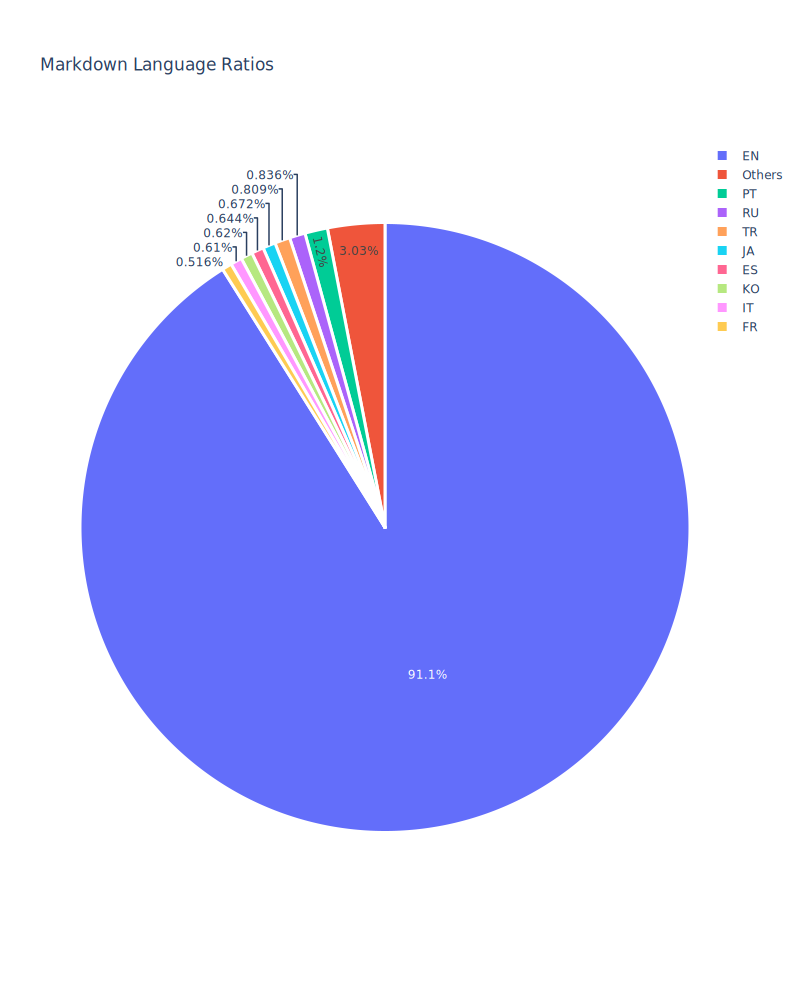

In [6]:
top_n = 9

language_counts = train_final['markdown_language'].value_counts()

top_n_languages = language_counts[:top_n]
other_languages = language_counts[top_n:]

language_counts_grouped = pd.DataFrame(top_n_languages).reset_index()
language_counts_grouped.columns = ['markdown_language', 'counts']
language_counts_grouped['markdown_language'] = language_counts_grouped['markdown_language'].apply(lambda x: x.upper())
language_counts_grouped.loc[top_n+1] = ['Others', sum(other_languages.values)]


fig = px.pie(language_counts_grouped, 
             values='counts', 
             names='markdown_language',
             width=800, 
             height=1000,
             title='Markdown Language Ratios')

fig.update_traces(textinfo='percent',
                  marker=dict(line=dict(color='white', width=3)))

fig.update_traces()

fig.show('svg')

In [ ]:
line_counts_codes_list = []
line_counts_markdowns_list = []

for r in range(train_final.shape[0]): 
    codes_line_list = ''.join(train_final['codes'][r]).split('\n')
    codes_line_list = [val for val in codes_line_list if val != '']
    line_counts_codes = len(codes_line_list)
    
    markdowns_line_list = ''.join(train_final['markdowns_cleaned'][r]).split('\n')
    markdowns_line_list = [val for val in markdowns_line_list if val != '']
    line_counts_markdowns = len(markdowns_line_list)
    
    line_counts_codes_list.append(line_counts_codes)
    line_counts_markdowns_list.append(line_counts_markdowns)
    
line_counts_codes_list = np.array(line_counts_codes_list)    
line_counts_markdowns_list = np.array(line_counts_markdowns_list)    

In [ ]:
train_final['codes_line_counts'] = line_counts_codes_list
train_final['markdowns_line_counts'] = line_counts_markdowns_list

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=line_counts_codes_list, 
                     name = 'Number of Lines (Codes)',
                     marker_color = 'indianred'))

fig.add_trace(go.Box(y=line_counts_markdowns_list,
                     name = 'Number of Lines (Markdowns)',
                     marker_color = 'lightseagreen'))

fig.update_layout(template = 'plotly_white',
                  width=1000,
                  height=600,
                  title="Distribution of the Number of Lines")
    

fig.show('svg')

In [ ]:
n = 1
n_line_markdown_ratio = np.mean(line_counts_markdowns_list<=n)
n_line_markdown_ratio = np.round(n_line_markdown_ratio, 2)

print("The ratio of notebooks that have lower than or equal to {} line(s) in their markdowns: {}".format(n, n_line_markdown_ratio))

In [ ]:
x = list(range(1,26))
y = [np.mean(line_counts_markdowns_list<=n) for n in x]

fig = go.Figure([go.Bar(x=x, y=y)])

fig.update_traces(marker_color='rgb(158,202,225)', 
                  marker_line_color='white',
                  marker_line_width=0.50, opacity=1)

fig.update_layout(template='plotly_white',
                  width=1000,
                  height=600,
                  title="Cumulative Bar Chart",
                  xaxis_title="Number of Lines",
                  yaxis_title="Ratio of Notebooks")

fig.update_xaxes(showline=True, 
                 showgrid=True, 
                 gridwidth=1.5, 
                 linewidth=2, 
                 nticks = max(x)+1)

fig.update_yaxes(showline=True, 
                 showgrid=True, 
                 gridwidth=1.5, 
                 linewidth=2, 
                 nticks=11,
                 range = [0,1])

fig.show('svg')

In [ ]:
line_counts_codes_sorted = pd.Series(line_counts_codes_list).sort_values(ascending=False)
long_codes_indices = line_counts_codes_sorted[line_counts_codes_sorted>100].index.tolist()

line_counts_markdowns_sorted = pd.Series(line_counts_markdowns_list).sort_values(ascending=False)
long_markdowns_indices = line_counts_markdowns_sorted[line_counts_markdowns_sorted>100].index.tolist()

In [ ]:
long_markdown = train_final['markdowns_cleaned'][long_markdowns_indices[398]][:3]
long_markdown_joined = '\n'.join(long_markdown)

print(long_markdown_joined)

In [ ]:
def translate(texts):
    translated_texts = [ts.google(val) for val in texts]
    return translated_texts

In [ ]:
# nonenglish_index = train_final['language']!='en'

In [ ]:
# train_final['markdowns_translated'] = None

In [ ]:
# train_final.loc[~nonenglish_index, 'markdowns_translated'] = train_final['markdowns_cleaned'][~nonenglish_index].values

In [ ]:
# from tqdm import tqdm
# tqdm.pandas()
# train_final.loc[nonenglish_index, 'markdowns_translated'] = train_final['markdowns_cleaned'][nonenglish_index].progress_apply(translate).values

In [ ]:
for val in range(len(markdowns)):
    print(markdowns[val])
    print()
    print('---------')
    print()
    print(translated_markdowns[val])
    print()
    print('#########')
    print()

In [ ]:
# ANCESTRY (?)